In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from utils.plots import *
from utils.funcs import *
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from utils.visualize_hidden_network import *

# firing rate

device = 'cpu'



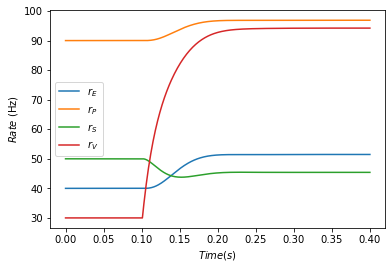

In [2]:
# Wee = 0.8 # NON_ISN
Wee = 1.2 # ISN
W = np.array([[Wee, -1, -1,  0], [1, -1, -0.5, 0], [1, 0, 0, -0.25], [1, 0, -0.6, 0]])

# parameters
N = 4

dt = 1e-3
tau = 20e-3 # s
I = np.eye(N)
m = 10
T = tau * I
r0 = m * np.array([4, 9, 5, 3])
B = m * np.array([0, 0, 0, 5])

t_range = np.arange(0.4/dt + 1)
T_stim = 0.1/dt

r = np.zeros([t_range.shape[0], r0.shape[0]])
dr = np.zeros([t_range.shape[0], r0.shape[0]])
dr_equilibrium = ([t_range.shape[0], r0.shape[0]])

r[0, :] = 0 + r0


for i, t in enumerate(t_range[0: - 1]):

    if t <= T_stim:
        b = np.zeros([W.shape[0]])
    else:
        b = B

    dr[i + 1, :] = np.matmul(np.linalg.inv(T), (np.matmul( (W - I), (r[i, :] - r0)) + b ))
    r[i + 1, :] = r[i, :] + dr[i + 1, :] * dt

dr_equilibrium = np.linalg.inv(W - I) * b

dI_I = np.sum( W[0, 1: ] * r[:, 1: ], 1)
dI_I = -(dI_I - dI_I[0])
dI_E = W[0, 0] * r[:, 0]
dI_E = dI_E - dI_E[0]

for i in range(r0.shape[0]):
    plt.plot(t_range * dt, r[:, i])
plt.xlabel('$Time (s)$')
plt.ylabel('$Rate$ (Hz)')
plt.legend(['$r_E$', '$r_P$', '$r_S$', '$r_V$'])
plt.show()

hidden_trace = np.zeros([4, t_range.shape[0]])
hidden_trace[0, :] = np.random.poisson(r[:, 0] * dt)
hidden_trace[1, :] = np.random.poisson(r[:, 1] * dt)
hidden_trace[2, :] = np.random.poisson(r[:, 2] * dt)
hidden_trace[3, :] = np.random.poisson(r[:, 3] * dt)
hidden_trace[hidden_trace < 0] = 0
hidden_trace[hidden_trace > 1] = 1

hidden_trace = torch.tensor(hidden_trace, dtype=torch.float, device=device)


In [3]:

def generate_data(W, B = np.array([0, 0, 0, 5])):

    # parameters
    N = 4

    dt = 1e-3
    tau = 20e-3 # s
    I = np.eye(N)
    m = 10
    T = tau * I
    r0 = m * np.array([4, 9, 5, 3])
    B = m * B

    t_range = np.arange(0.15/dt + 1)
    T_stim = 0#0.05/dt

    r = np.zeros([t_range.shape[0], r0.shape[0]])
    dr = np.zeros([t_range.shape[0], r0.shape[0]])
    dr_equilibrium = ([t_range.shape[0], r0.shape[0]])

    r[0, :] = 0 + r0


    for i, t in enumerate(t_range[0: - 1]):

        if t <= T_stim:
            b = np.zeros([W.shape[0]])
        else:
            b = B

        dr[i + 1, :] = np.matmul(np.linalg.inv(T), (np.matmul( (W - I), (r[i, :] - r0)) + b ))
        r[i + 1, :] = r[i, :] + dr[i + 1, :] * dt

    hidden_trace = np.zeros([4, t_range.shape[0]])
    hidden_trace[0, :] = np.random.poisson(r[:, 0] * dt)
    hidden_trace[1, :] = np.random.poisson(r[:, 1] * dt)
    hidden_trace[2, :] = np.random.poisson(r[:, 2] * dt)
    hidden_trace[3, :] = np.random.poisson(r[:, 3] * dt)
    hidden_trace[hidden_trace < 0] = 0
    hidden_trace[hidden_trace > 1] = 1

    hidden_trace = torch.tensor(hidden_trace, dtype=torch.float, device=device)

    return hidden_trace

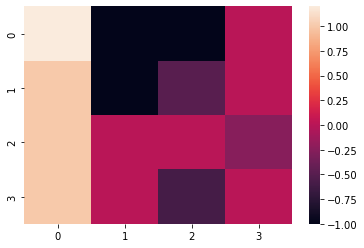

tensor(32.)

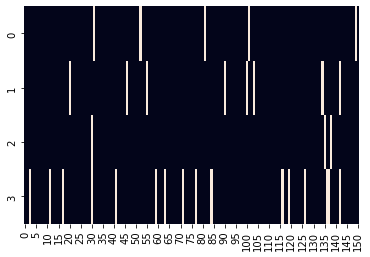

In [4]:
# Wee = 0.8 # NON_ISN
Wee = 1.2 # ISN
W = np.array([[Wee, -1, -1,  0], [1, -1, -0.5, 0], [1, 0, 0, -0.25], [1, 0, -0.6, 0]])

B = np.zeros(4)
B[0] = np.random.randint(low=0, high=5)
B[3] = np.random.randint(low=0, high=5)

hidden_trace = generate_data(W, B)
sns.heatmap(W)
plt.show()
sns.heatmap(hidden_trace, cbar=False)
torch.sum(hidden_trace)


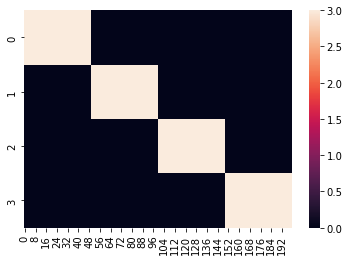

tensor(0.5285)

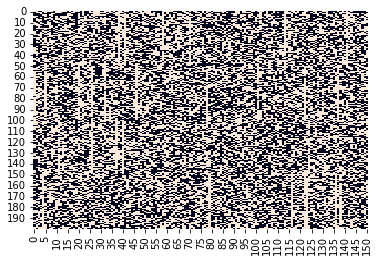

In [5]:
n_batches = 120
N_H, T = hidden_trace.shape
N_V = 50 * N_H
spikes = torch.zeros([N_V, T, n_batches])

VH = 0 * torch.rand([N_H, N_V])
for i in range(N_H):
    VH[i, i*50 : (i+1)*50] = 3 * torch.ones([1, 50])
sns.heatmap(VH)
plt.show()

for batch in range(n_batches):
    B = np.zeros(4)
    B[0] = np.random.randint(low=0, high=5)
    hidden_trace = generate_data(W, B)
    spikes[:, :, batch] = torch.bernoulli(torch.sigmoid(torch.matmul(VH.T, hidden_trace) + 0))

sns.heatmap(spikes[:, :, 0], cbar=False)
torch.mean(spikes)

100%|██████████| 1500/1500 [1:12:02<00:00,  2.88s/it]


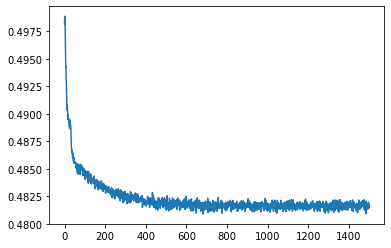

In [6]:
rtrbm = RTRBM_nobias(spikes, N_H=4, device='cpu')
rtrbm.learn(n_epochs=1500, batchsize=10, lr=1e-3, lr_end=1e-5, start_decay=200)
plt.plot(rtrbm.errors)


In [7]:
corr = np.zeros((N_H, N_H))
shuffle_idx = np.zeros((N_H))
for i in range(N_H):
    for j in range(N_H):
        corr[i, j] = np.correlate(VH, rtrbm.W[j,:])
    shuffle_idx[i] = np.argmax(corr[i,:])

W_train = rtrbm.W[shuffle_idx, :].clone()
W_acc_train = rtrbm.U[shuffle_idx, :].clone()
W_acc_train = rtrbm.U[:, shuffle_idx].clone()

ValueError: object too deep for desired array

<function matplotlib.pyplot.show(close=None, block=None)>

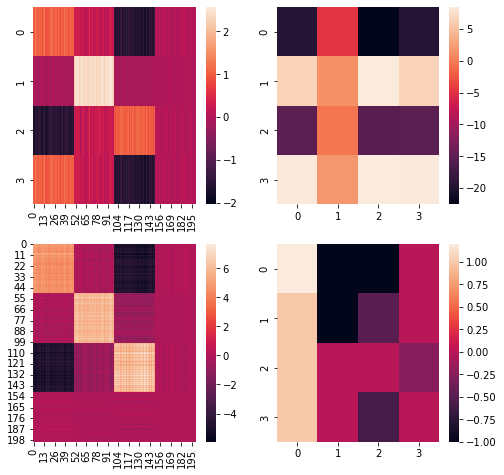

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.heatmap(W_train, ax=ax[0, 0])
sns.heatmap(W_acc_train, ax=ax[0, 1])
sns.heatmap(torch.matmul(W_train.T, W_train), ax=ax[1, 0])
sns.heatmap(W, ax=ax[1,1])
plt.show

In [58]:
n_neurons_pop = 50
n_pop = 4
rads = torch.linspace(0, 2*torch.pi, n_pop + 1)
mean_locations_pop = torch.zeros(n_pop, 2)
coordinates = torch.zeros(n_neurons_pop*n_pop, 2)
for i in range(n_pop):
    if i < 9:
        mean_locations_pop[i, :] = torch.tensor([torch.cos(rads[i]), torch.sin(rads[i])])
    else:
        mean_locations_pop[i, :] = torch.tensor([0, 0])
    coordinates[n_neurons_pop * i:n_neurons_pop * (i + 1), :] = 0.15 * torch.randn(n_neurons_pop, 2) + mean_locations_pop[i]

In [60]:
rf

tensor([[ 0.7143, -0.2443],
        [-0.0053,  0.6906],
        [-0.7272, -0.2948],
        [    nan,     nan]])

TypeError: Got both 'size' and 'fontsize', which are aliases of one another

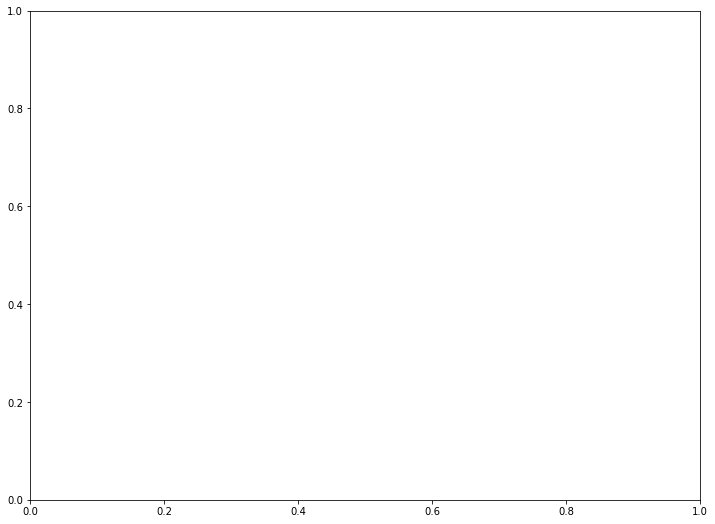

In [59]:
rf = get_hidden_mean_receptive_fields(W_train, coordinates, only_max_conn=True)
create_plot(W_train, W_acc_train, rf,  coordinates, 0, weight_line_factor=1, hiddens_radius=0.1, hidden_weight_thresh=0.1)
plt.axis('off')

In [54]:
import numpy as np
from math import cos, sin, atan2
from palettable.tableau import Tableau_10, Tableau_20
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad
import torch


def create_plot(VH, HH, rf, coords, dy, dx=0, markersize_visibles=20, hiddens_radius=0.02, weight_line_factor=1, hidden_weight_thresh=0):
    plt.figure(figsize=(10, 10))
    x_hidden_mean_receptive_fields = rf[:, 0]
    y_hidden_mean_receptive_fields = rf[:, 1]

    N_H = HH.shape[0]
    for h in range(N_H):
        draw_neuron(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h], hiddens_radius, id=h)

    for h in range(N_H):
        for hh in range(N_H):
            if abs(HH[h, hh]) > hidden_weight_thresh:
                if h < hh:
                    dy = -dy
                    dx = -dx
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)
                else:
                    dy = abs(dy)
                    dx = abs(dx)
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)

    plot_VH_connections(plt.gca(), VH, coords, markersize=markersize_visibles)

    plt.gca().set_xlim(torch.min(coords[:, 0]), torch.max(coords[:, 0]))
    plt.gca().set_ylim(torch.min(coords[:, 1]), torch.max(coords[:, 1]))

    plt.plot(coords[:, 0], coords[:, 1], 'g.', markersize=1, zorder=-10)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)



def draw_neuron(x, y, neuron_radius, id=-1):
    # circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2*id])
    # plt.gca().add_patch(circle)
    # plt.gca().text(x, y-(neuron_radius/4), str(id), size=neuron_radius*1000, ha='center')

    circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2 * id])
    plt.gca().add_patch(circle)
    #plt.gca().text(x, y-0.03, str(id), size=neuron_radius * 1000, ha='center', fontsize=20)


def line_between_two_neurons(neuron1_x, neuron1_y, neuron2_x, neuron2_y, neuron_radius, weight=0.4,
                             weight_line_factor=1):
    angle = atan2(neuron2_x - neuron1_x, neuron2_y - neuron1_y)
    x_adjustment = neuron_radius * sin(angle)
    y_adjustment = neuron_radius * cos(angle)

    # assign colors to lines depending on the sign of the weight
    color = Tableau_10.mpl_colors[3]
    if weight > 0: color = Tableau_10.mpl_colors[2]

    # assign different linewidths to lines depending on the size of the weight
    abs_weight = abs(weight)
    linewidth = 2 * abs_weight * weight_line_factor

    # draw self-connecting arrow
    if neuron1_x == neuron2_x:
       drawCirc(plt.gca(), neuron_radius * 2, neuron1_x, neuron1_y, -30, 230, color_=color, lw=3 * linewidth)

    # draw arrow
    else:
       plt.gca().arrow(neuron1_x + x_adjustment, neuron1_y + y_adjustment,
                       neuron2_x - neuron1_x - 2 * x_adjustment, neuron2_y - neuron1_y - 2 * y_adjustment,
                       lw=3 * linewidth, color=color, length_includes_head=True, head_width=linewidth/20, overhang=0)

def drawCirc(ax, radius, centX, centY, angle_, theta2_, color_='black', lw=1):
    # ========Line
    if lw > 0.1:
        arc = Arc([centX, centY + radius / 2], radius, radius, angle=angle_,
                  theta1=0, theta2=theta2_, capstyle='round', linestyle='-', lw=lw, color=color_)
        ax.add_patch(arc)

        # ========Create the arrow head
        endX = centX + (radius / 2) * np.cos(rad(theta2_ + angle_))  # Do trig to determine end position
        endY = centY + (radius / 2) * np.sin(rad(theta2_ + angle_))

        ax.add_patch(  # Create triangle as arrow head
            RegularPolygon(
                (endX, endY + radius / 2),  # (x,y)
                3,  # number of vertices
                radius / 9,  # radius
                rad(angle_ + theta2_),  # orientation
                color=color_
            )
        )
    # ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius])
    # Make sure you keep the axes scaled or else arrow will distort


def plot_VH_connections(ax, VH, coordinates, strong_thresh=0.5, markersize=2):
    N_H, N_V = VH.shape
    max_hidden_connection = torch.max(VH, 0)[1]

    for h in range(N_H):
        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h) % 20], s=markersize)

        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h + 1) % 20], s=markersize)
        ax.set_xlabel('x', fontsize=28)
        ax.set_ylabel('y', fontsize=28)
        ax.tick_params(axis='both', which='major', labelsize=20)

